In [1]:
import scipy.optimize as spo
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nlg

import ertools as er
import timeseriestools as ts
import regiontools as rt

import xarray as xr
import matrixtools as mt

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

In [2]:
def makeTS(ds,var):
    X = ds[var].values
    lon = ds.lon.values
    lat = ds.lat.values
    val = np.logical_not(np.isnan(X[0,:,:]))

    area = np.outer(np.cos(np.pi*lat/180), np.ones(len(lon)))
    x = X[:,val]
    area = area[val]

    x = np.dot(x,area)/np.sum(area)

    return x

# Notebook used to conduct canonical correlation analysis on Sea Surface Temperatures and Precipitation

In [3]:
ds = xr.open_dataset('Data/CPC/Precip/precip.mon.mean.nc')
globe_precip = makeTS(ds,'precip')

precip = ds.precip.values
lon_precip = ds.lon.values
lat_precip = ds.lat.values


sst = er.all_sstInRegion(1979,2021,[0,360],[-90,90])
lon_sst,lat_sst = er.readLonLat()


globe_sst = er.erTimeSeries(1979,2021,[0,360],[-90,90])


In [ ]:
globe_precip = ts.removeCycle(globe_precip)
globe_sst = ts.removeCycle(globe_sst)

precip = rt.removeGridCycle(precip)
sst = rt.removeGridCycle(sst)
precip = rt.detrendRegion(precip,1,False)
sst = rt.detrendRegion(sst,1,False)



sst = sst - np.mean(sst,axis=0)
precip = precip - np.mean(precip,axis=0)


### Getting the CCA for sst and precip

In [ ]:
cca = mt.cca(sst,precip,lon_sst,lat_sst,lon_precip,lat_precip)
cca.keys()

dict_keys(['Rx', 'Ry', 'Px', 'Py', 'rho', 'nx', 'ny', 'mic'])

In [ ]:
n = 0
P_sst = cca['Px']
P_precip = cca['Py']
P_precip.shape

P_list = [P_sst[n,:,:],P_precip[n,:,:]]
lon_list = [lon_sst,lon_precip]
lat_list = [lat_sst,lat_precip]

title_list = ['SST', 'Precip']

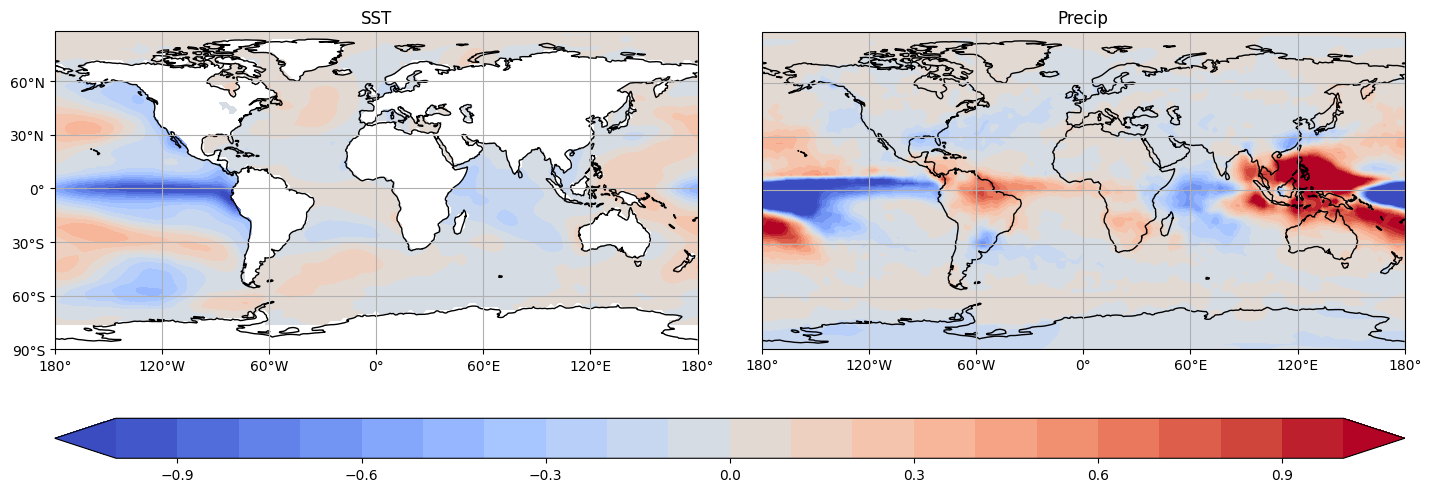

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=2,subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(15,8))
axs = axs.flatten()

for i,ax in enumerate(axs):
    lon = lon_list[i]
    lat = lat_list[i]
    P = P_list[i]
    title = title_list[i]

    P,lon = add_cyclic_point(P,coord=lon)

    cs = ax.contourf(lon,lat,P,cmap='coolwarm',levels=np.arange(-1.,1.1,.1),extend='both',transform=ccrs.PlateCarree())
    
    ax.coastlines()
    ax.gridlines()
    ax.set_title(title)

    ax.set_xticks(np.arange(-180,181,60))
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    if(i==0):
        ax.set_yticks(np.arange(-90,90,30))
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

fig.subplots_adjust(bottom=0.07,top=0.9,left=0.05,right=0.95,wspace=0.1,hspace=0.1)
cbar_ax = fig.add_axes([0.05,0.15,0.9,0.05])
cbar=fig.colorbar(cs,cax=cbar_ax,orientation='horizontal')#,label='RMS/RMS_clim')
plt.show()
    

In [ ]:
R_sst = cca['Rx']
R_precip = cca['Ry']

R_precip.shape

(509, 30)

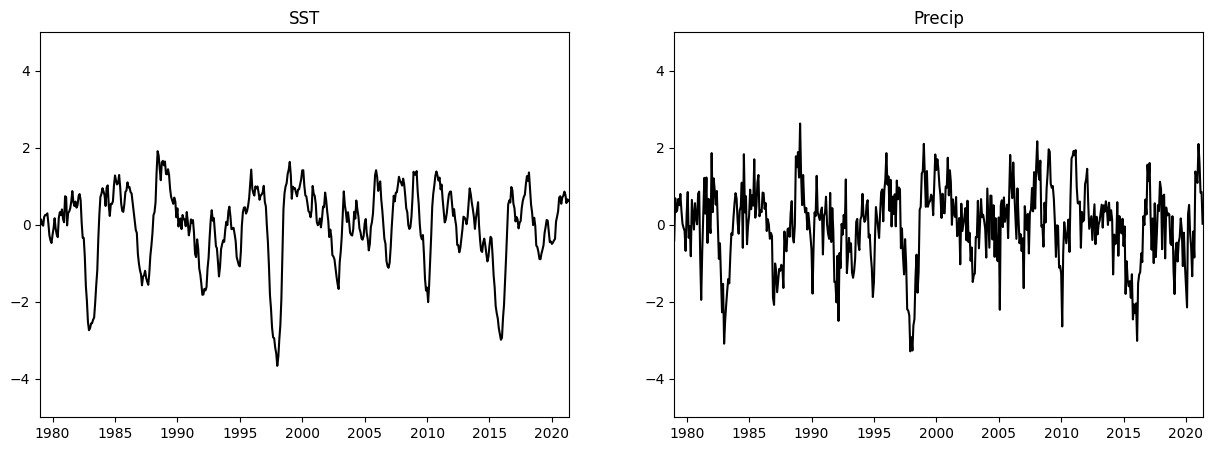

In [ ]:
r_list = [R_sst[:,n],R_precip[:,n]]
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axs = axs.flatten()
time = ds.time.values
for i, ax in enumerate(axs):
    title = title_list[i]
    r = r_list[i]

    ax.plot(time,r,'k')
    ax.set_title(title)
    ax.axis([min(time),max(time),-5,5])

plt.show()

In [ ]:
rho = cca['rho']
rho = rho[n]
print(rho)

0.9506049077284042
